This notebook explores curve fitting for aggregate (15min) SCOOT data. 

Two models are fitted to the data:
1. Linear Hybrid Exponential  
    Piecewise function, fit linear until a threshold and fit exponential to the rest.
    The threshold is determined by looping through 15th to 85th percentile in increments of 5th percentile and choosing the one with the least the sum of absolute error.
    
2. Linear

By passing 'remove_outliers = False' to function my_curve_fit, outliers will be included in curve fitting. Default is to take out anything that's 3 times more or 1/3 less of the video counts.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pg import DB
import configparser
import warnings
warnings.simplefilter('error',RuntimeWarning)
from scoot_utilities import *

In [3]:
# Database connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [4]:
# Set up
# Set up the centrelines and detectors in the scope of this analysis
centrelines = [3304786,446523,30018925,30018925,1147201,1147201,1147026,1147466,8540609,8571185,11466484,1141946]
dir_bins = [1,-1,1,-1,1,-1,1,1,1,-1,1,-1]
sdetectors = [['\'N12921J1\'','\'N12921J2\''],['\'N12931A1\'','\'N12931A2\''],['\'N12821C1\'','\'N12821C2\'','\'N12821C3\''],['\'N12851G1\'','\'N12851G2\''],['\'N30431K1\'','\'N30431K2\''],['\'N30421B1\'','\'N30421B2\''],['\'N30611K1\'','\'N30611K2\''],['\'N30311D1\'','\'N30311D2\''],['\'N21521K1\''],['\'N21521H1\''],['\'N21421D1\''],['\'N21311B1\'']]
locations = ['Don Mills NB N of Overlea','Don Mills SB S of Gateway','Don Mills NB N of Clock Tower','Don Mills SB S of Lawrence','Lake Shore EB E of Stadium','Lake Shore WB W of Bathurst','Lake Shore EB E of Spadina','Lake Shore EB E of Ontario Place','Bloor EB W of Castle Frank','Bloor WB E of Castle Frank','Bloor EB E of Church','Bloor WB W of Church']
aggregation = [[['lane1','lane2'],['lane3']],
               [['lane1','lane2'],['lane3']],
               [['lane1'],['lane2'],['lane3']],
               [['lane2','lane3'],['lane1']],
               [['lane1','lane2'],['lane3']],
               [['lane3'],['lane1','lane2']],
               [['lane1'],['lane2','lane3']],
               [['lane1'],['lane2','lane3']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']]]
det_lane = {'N12921J1':2,'N12921J2':1,'N12931A1':2,'N12931A2':1,'N12821C1':1,'N12821C2':1,'N12821C3':1,
                 'N12851G1':2,'N12851G2':1,'N30431K1':2,'N30431K2':1,'N30421B1':1,'N30421B2':2,'N30611K1':1,
                 'N30611K2':2,'N30311D1':1,'N30311D2':2,'N21521K1':2,'N21521H1':2,'N21421D1':2,'N21311B1':2}

In [5]:
# Retrieve Data from the database
video = pd.DataFrame(db.query('SELECT * FROM scoot.video_counts').getresult(), \
                     columns = ['time_start','time_end','lane1','lane2','lane3','Volume','centreline_id','dir_bin','count_date','seconds'])
video['CycleTime'] = 20
scoot_agg = pd.DataFrame(db.query('SELECT detector, start_time, flow_mean, EXTRACT(HOUR FROM start_time)*3600 + EXTRACT(MINUTE FROM start_time)*60 AS seconds  FROM scoot.agg_15_201704 WHERE start_time::date = \'2017-04-19\' AND detector IN (' + ','.join([y for x in sdetectors for y in x ]) + ')').getresult(), \
                         columns = ['detector', 'count_time', 'Volume', 'seconds'])
scoot_agg['Volume'] = scoot_agg['Volume']//4

In [6]:
# Parameters
# Video counts do not start until 15min into the day. will report error if 00:00:00 is entered as start time
start_hour = 0
start_min = 15
start_sec = 0
end_hour = 23
end_min = 59
end_sec = 59

offsets = [0,0,0,0,0,0,0,0,0,0,0,0]
bin_sec = 900

start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec
num_bins = (end_time_sec - start_time_sec)//bin_sec
min_bins_start_15 = list(np.linspace(start_time_sec, start_time_sec+bin_sec*num_bins, num_bins+1))
bins = [x//bin_sec for x in min_bins_start_15]
bins = bins[:-1]

Don Mills NB N of Overlea


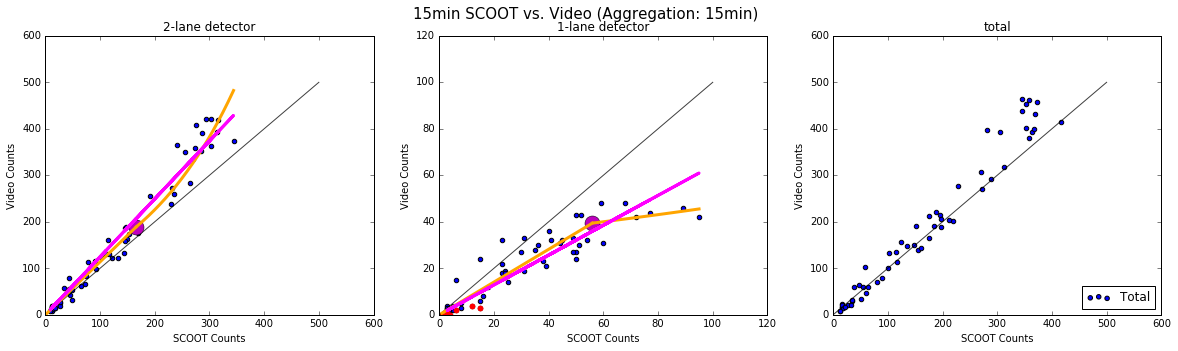

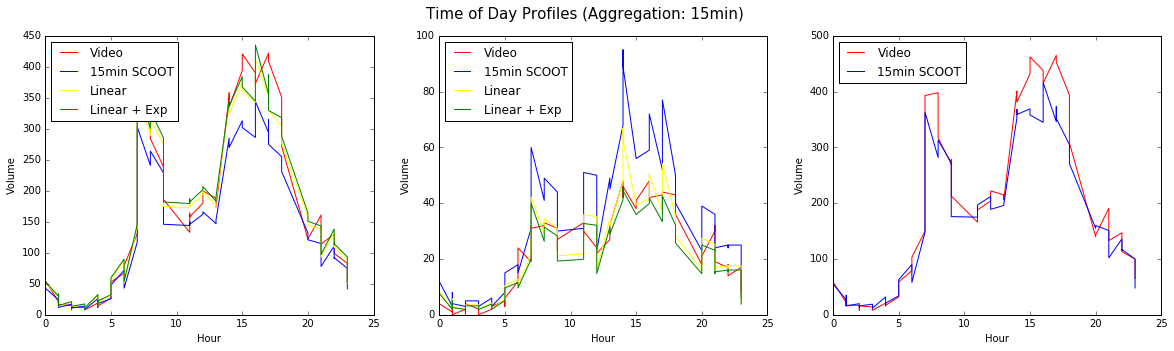

Don Mills SB S of Gateway


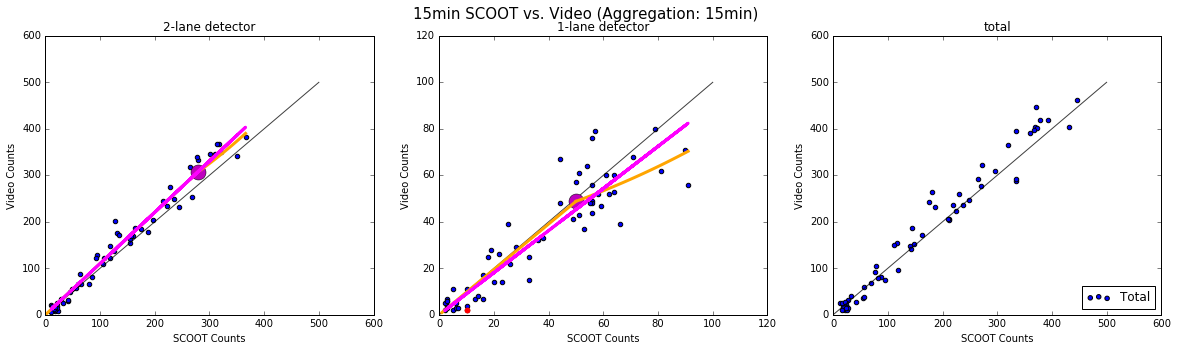

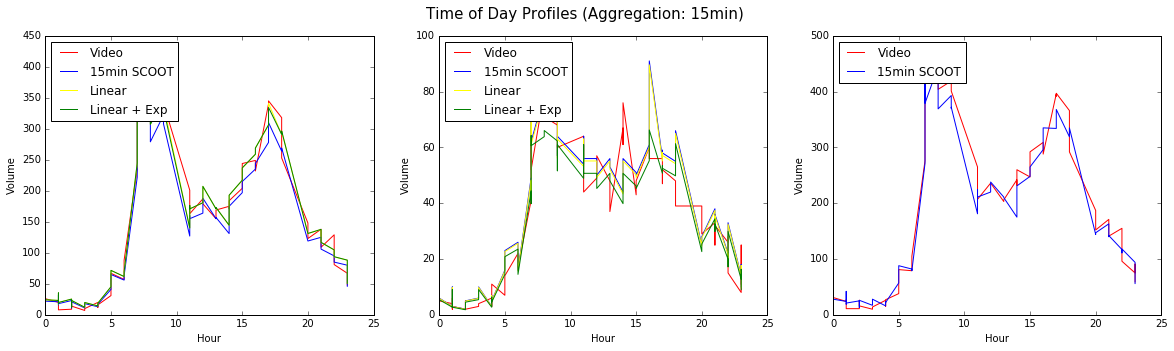

Don Mills NB N of Clock Tower


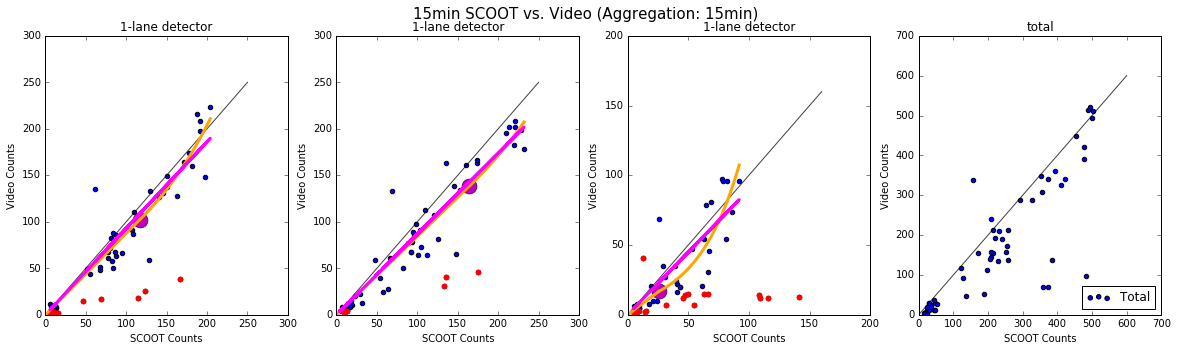

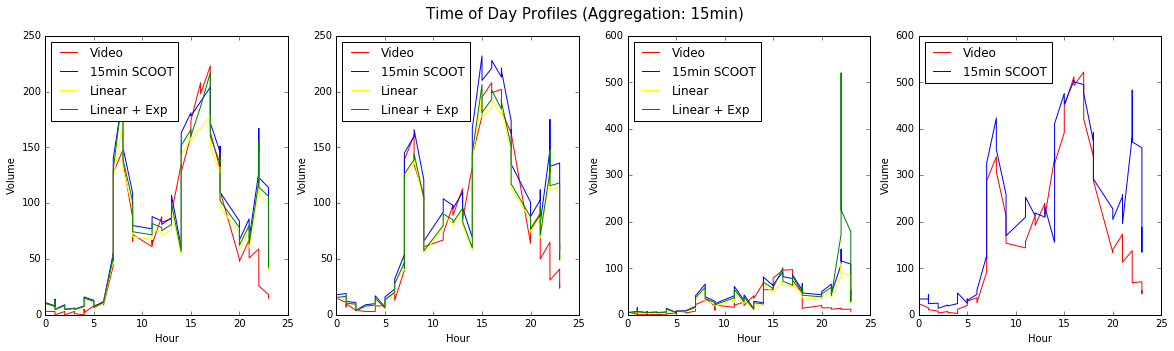

Don Mills SB S of Lawrence


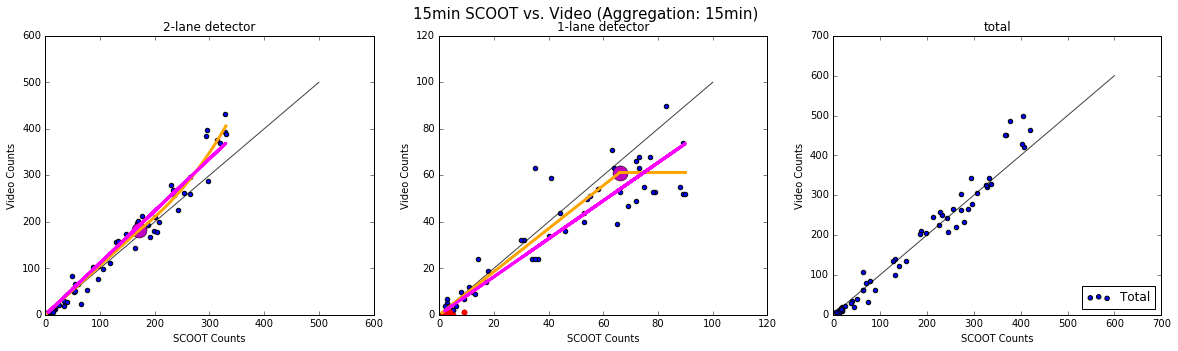

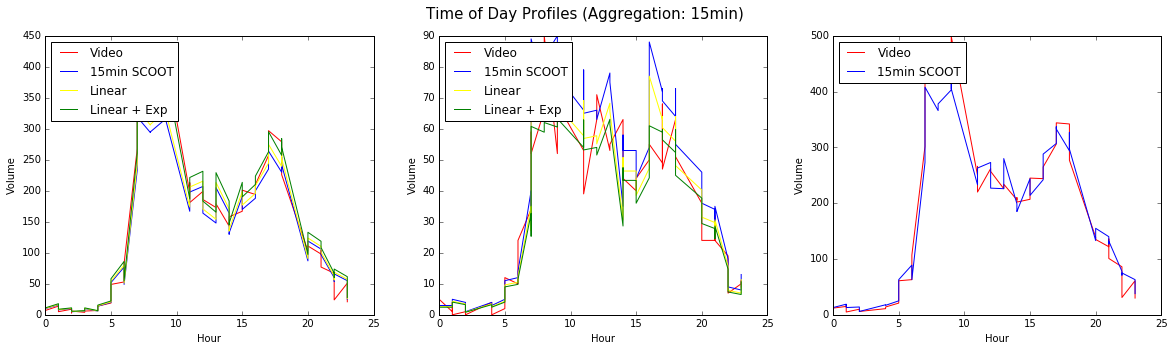

Lake Shore EB E of Stadium


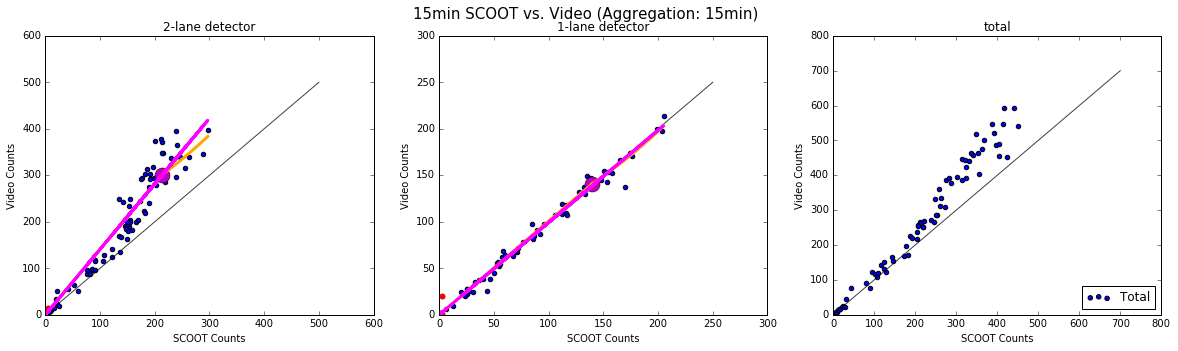

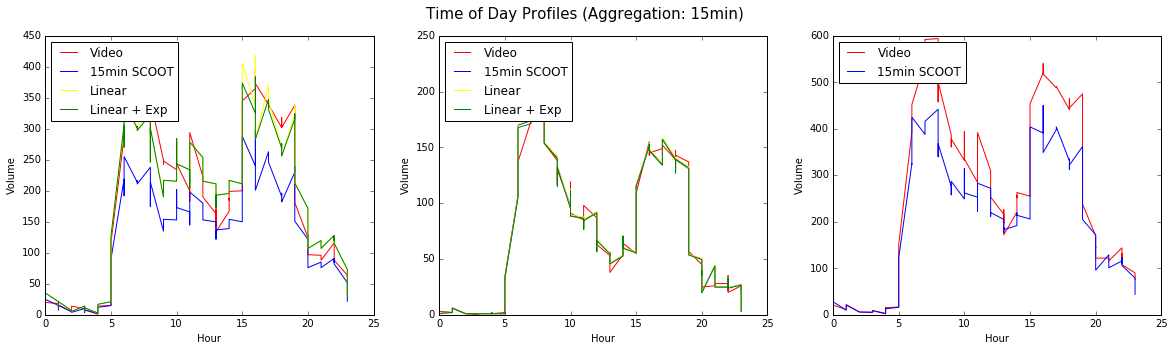

Lake Shore WB W of Bathurst


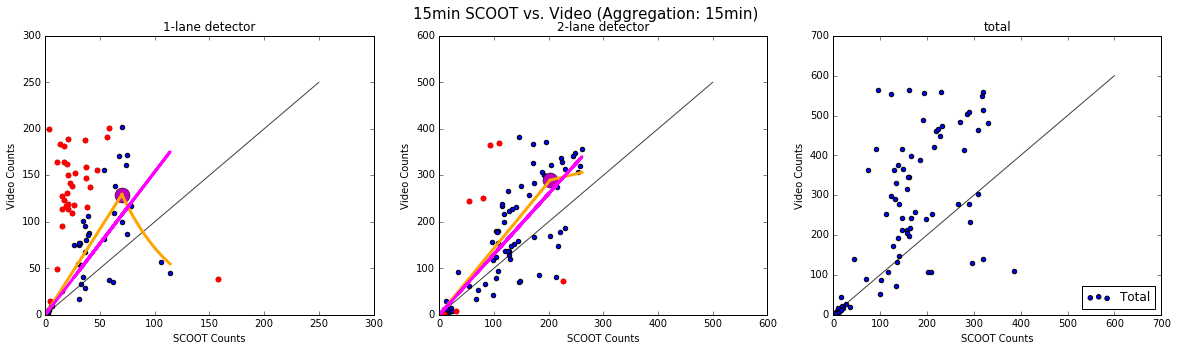

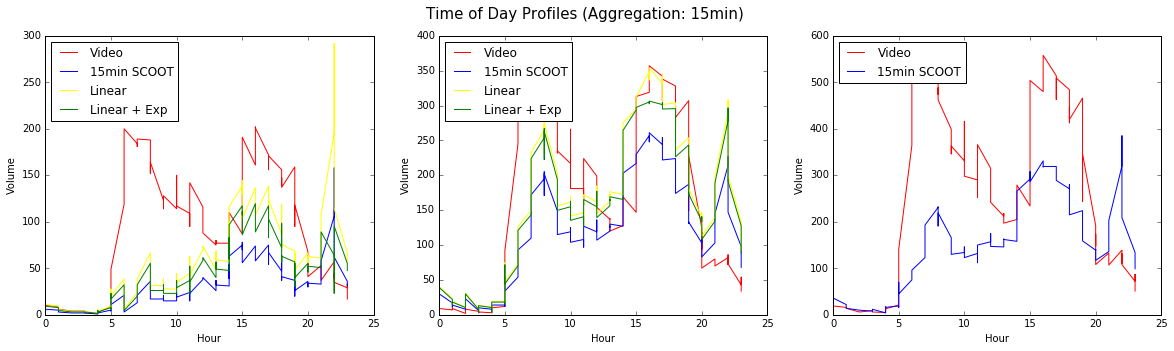

Lake Shore EB E of Spadina


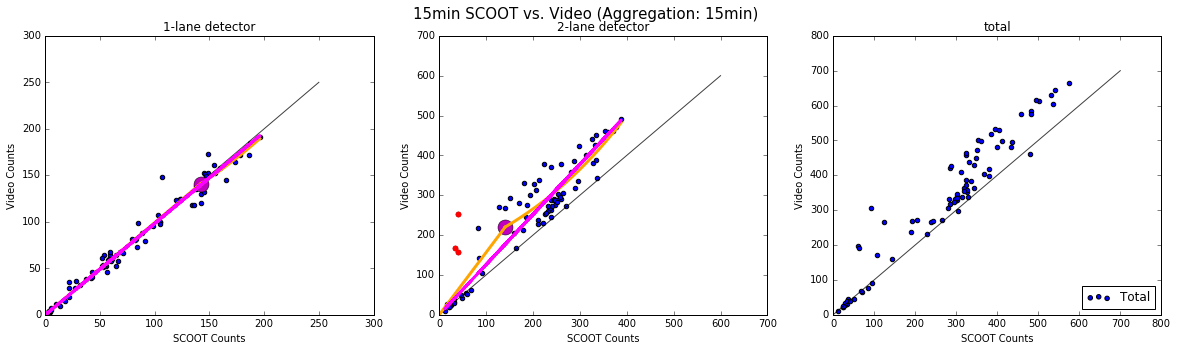

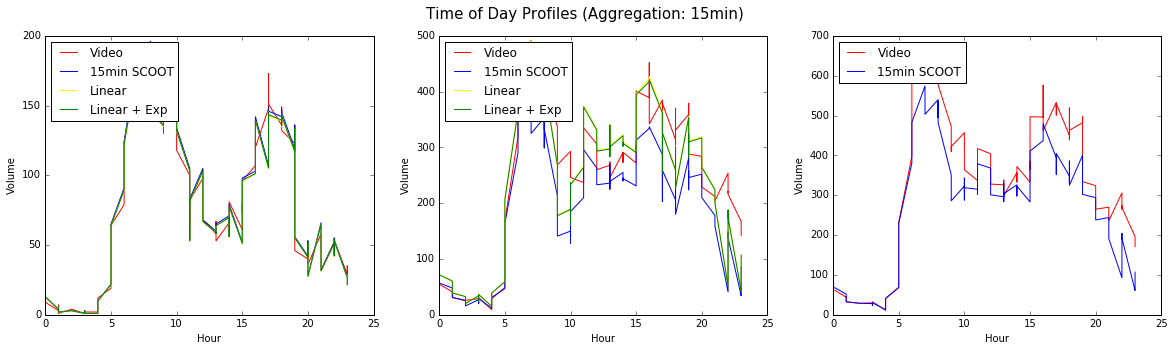

Lake Shore EB E of Ontario Place


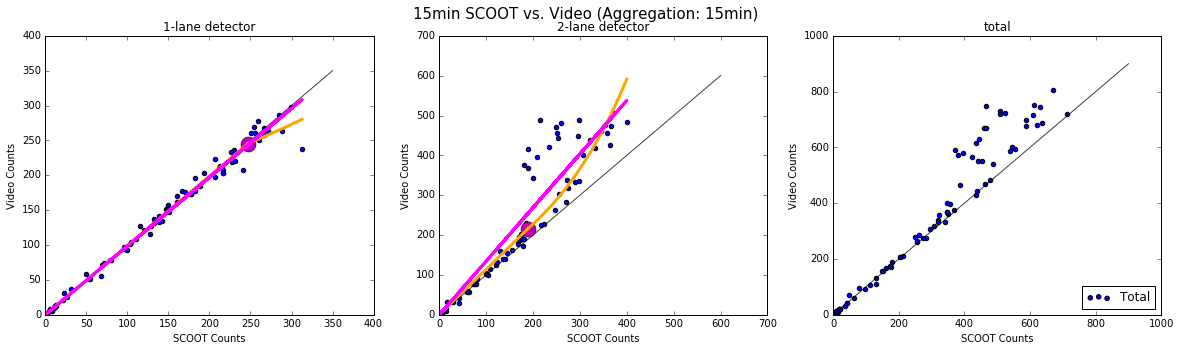

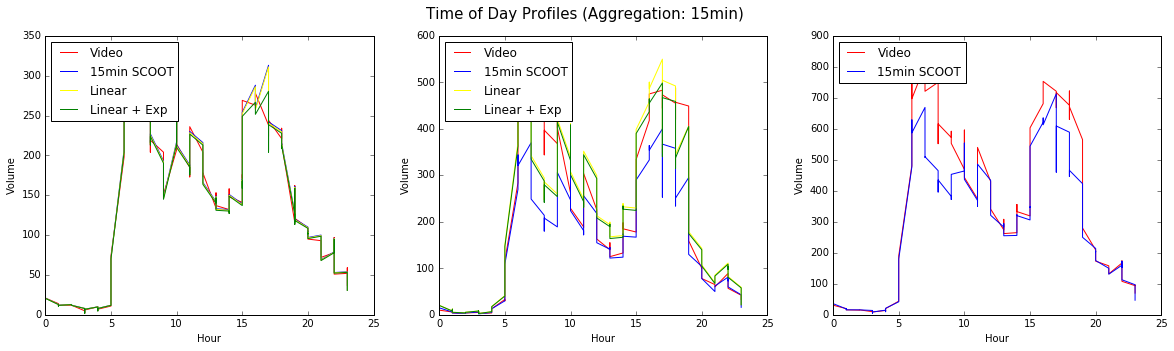

Bloor EB W of Castle Frank


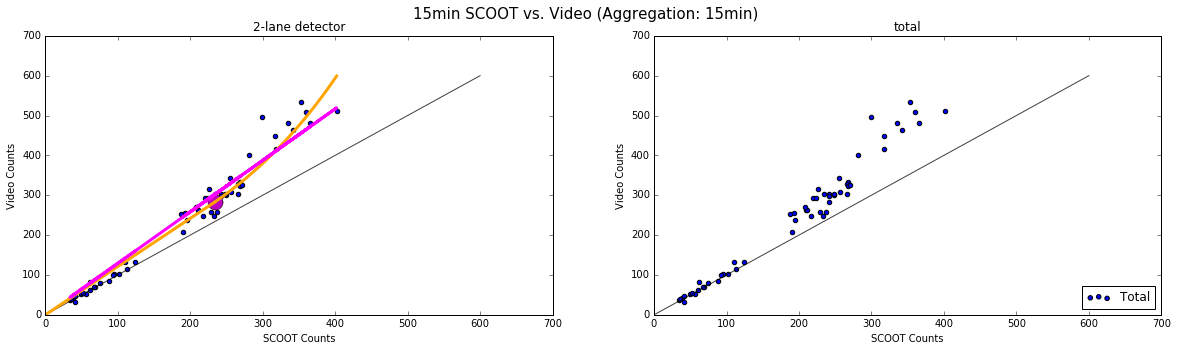

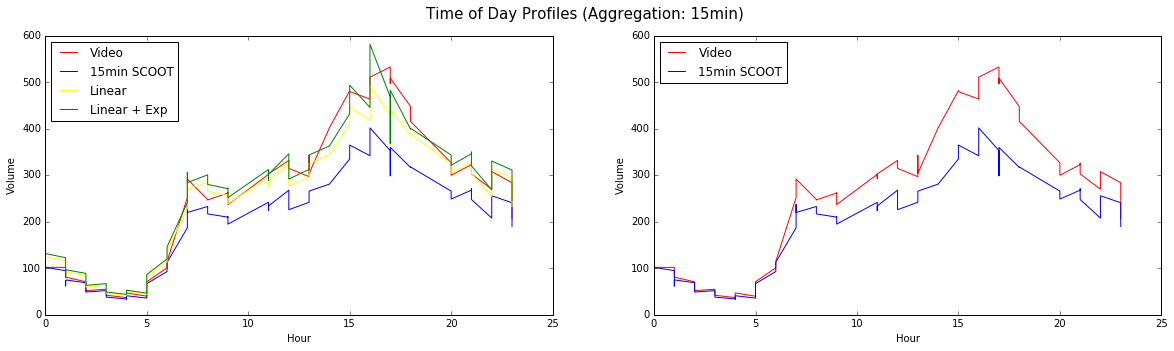

Bloor WB E of Castle Frank


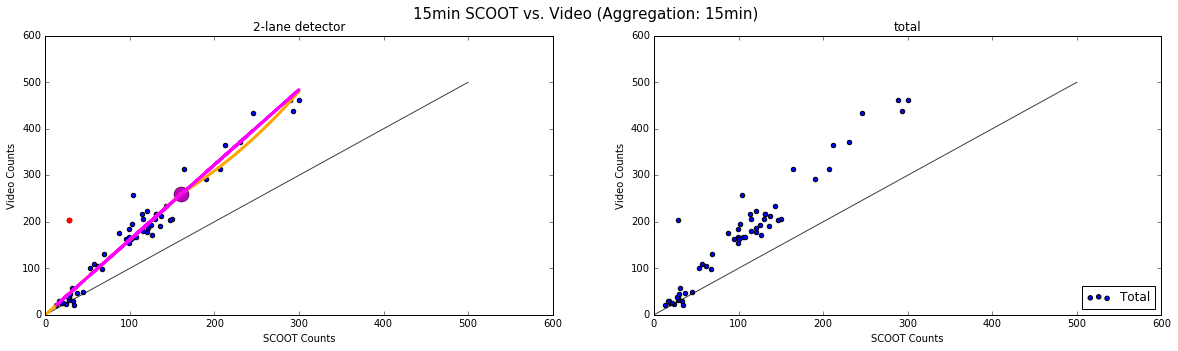

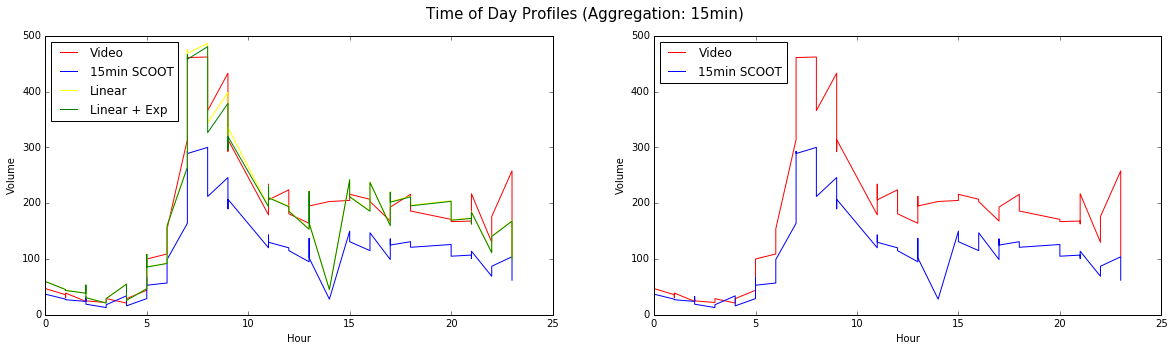

Bloor EB E of Church


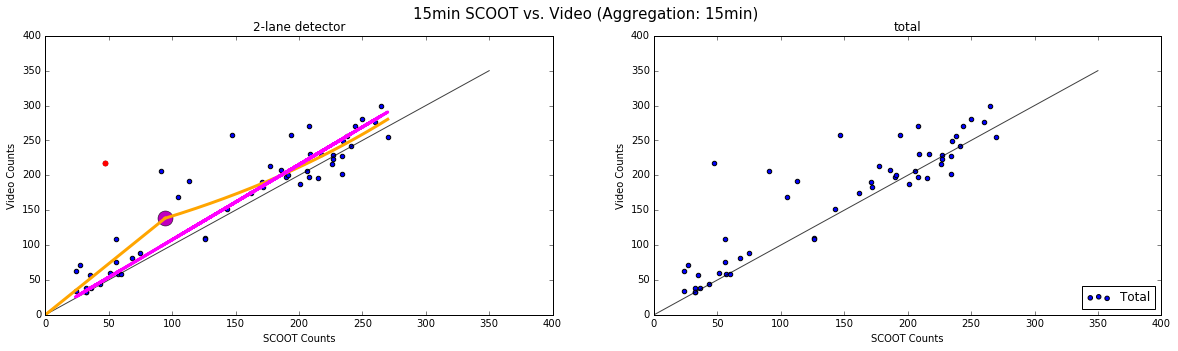

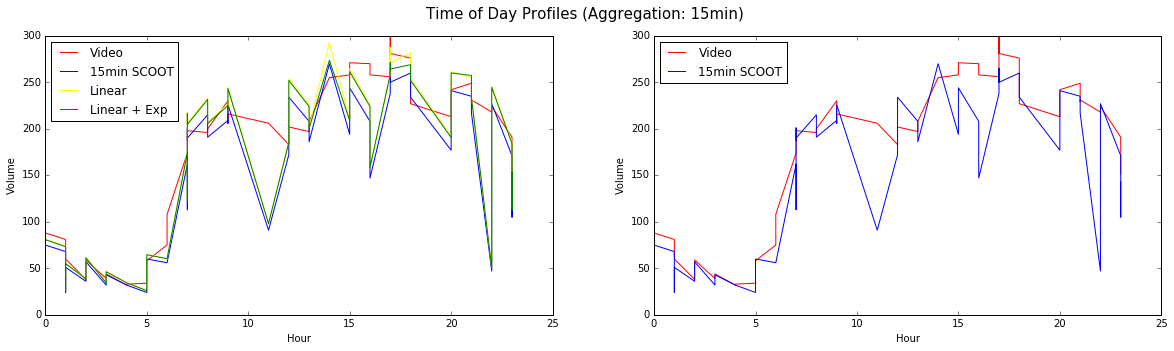

Bloor WB W of Church


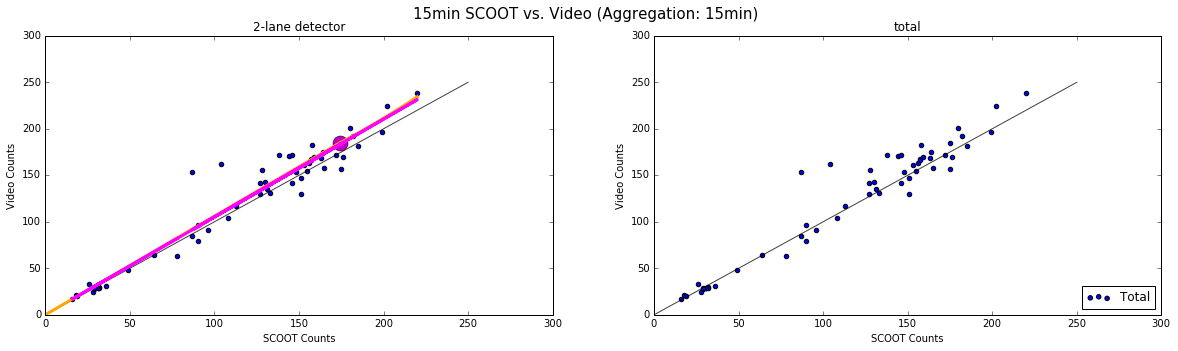

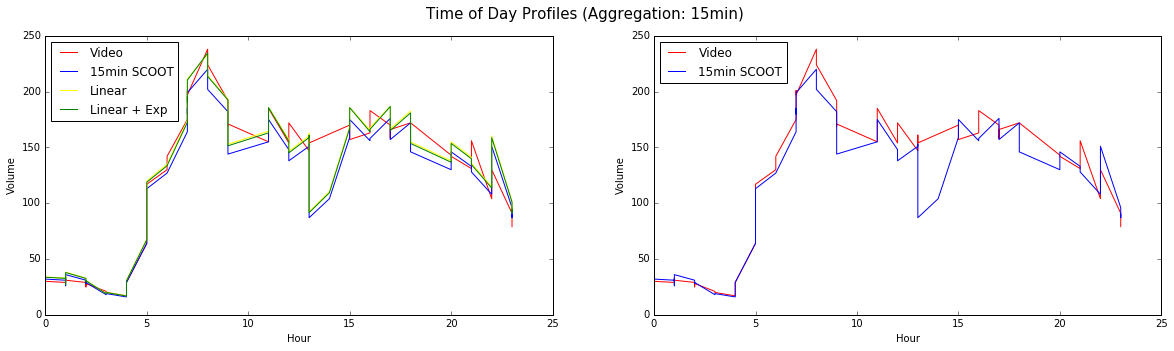

In [57]:
for i in range(len(locations)):
    RSS = []
    sdet = [x.strip('\'') for x in sdetectors[i]]
    tcl = centrelines[i]
    dir_bin = dir_bins[i]
    offset = offsets[i]
    iterables = []
    
    print(locations[i])

    # Time Filter 
    r = video[(video['seconds']>=start_time_sec-offset) & (video['seconds']<=end_time_sec-offset) & (video['centreline_id']==tcl) & (video['dir_bin']==dir_bin)].copy()
    r['bin'] = r['seconds']//bin_sec
    
    s_a = scoot_agg[(scoot_agg['seconds']>=start_time_sec) & (scoot_agg['seconds']+900<=end_time_sec)].copy()
    s_a = s_a[s_a['detector'].isin([x.strip('\'') for x in sdet])]
    
    # Aggregate lanes to individual detectors
    r = aggregate_lanes(r, aggregation[i])
    
    # Offset video counts
    r['seconds']=r['seconds']+offset

    # Reset Index
    r.reset_index(inplace=True, drop=True)
    s_a.reset_index(inplace=True, drop=True)
    
    # Create Figures
    fig_a,(ax_a) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # aggregate vs video
    fig_tod, (ax_tod) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # time of day plots
    fig.suptitle('Cycle Level SCOOT vs. Video (Aggregation: SCOOT CYCLE)', fontsize=15)
    fig_a.suptitle('15min SCOOT vs. Video (Aggregation: 15min)', fontsize=15)
    fig_tod.suptitle('Time of Day Profiles (Aggregation: 15min)', fontsize=15)
    
    # Plot Individual Detectors
    for det in range(len(sdet)):
        # 15min Aggregate vs. Video
        s0_a = s_a[s_a['detector'] == sdet[det]].copy()
        s0_a['bin'] = s0_a['seconds']//bin_sec
        v0_a = aggregate_data(min_bins_start_15, r, 'detector'+str(det))
        v0_a = pd.DataFrame({'bin':bins, 'v_v':v0_a})
        
        # Plot time bins with count
        vol = pd.merge(s0_a, v0_a, on='bin', how='inner', copy=False)
        vol = vol[vol['Volume']!=0]
        
        # Plot
        ax_a[det].scatter(vol['Volume'], vol['v_v'], label=None)
        add_y_eq_x(ax_a[det])
        ax_a[det].set_title(str(det_lane[sdet[det]]) + '-lane detector')
        ax_a[det].set_ylabel('Video Counts')
        ax_a[det].set_xlabel('SCOOT Counts')
        ax_a[det].set_xlim(xmin = 0)
        ax_a[det].set_ylim(ymin = 0)
        
        # Fit #1: Linear + Exp
        model1, popt, step = my_curve_fit(ax_a[det], list(vol['Volume']), list(vol['v_v']), func_lin, func2=func_exp, color='orange', fitname='Hybrid Exp Fit', p02=[9,0.0024], remove_outliers=True)
        
        # Fit #2: Linear
        model2 = my_curve_fit(ax_a[det], list(vol['Volume']), list(vol['v_v']), func_lin, color='magenta', fitname='Linear Fit', remove_outliers=True)
        
        # Plot
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['v_v'], label = 'Video', color = 'r')
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['Volume'], label = '15min SCOOT', color = 'b')
        ax_tod[det].plot([x//4 for x in vol['bin']], model1.predict(vol['Volume']), label = 'Linear', color = 'yellow')
        ax_tod[det].plot([x//4 for x in vol['bin']], [model2.predict(x) if x <= step else func_exp(x, *popt) for x in list(vol['Volume'])], label = 'Linear + Exp', color = 'green')
        ax_tod[det].set_ylabel('Volume')
        ax_tod[det].set_xlabel('Hour')
        ax_tod[det].set_xlim(xmin = 0)
        ax_tod[det].set_ylim(ymin = 0)
        ax_tod[det].legend(loc=2)
        
    det = det + 1
    
    # Plot Total
    # Aggregate Total
    s_a = s_a[s_a['Volume']!=0]
    s_a = s_a.groupby(['seconds'], as_index=False).filter(lambda x: len(x) == len(sdet))
    s_a = s_a.groupby(['seconds'], as_index=False).sum()
    s_a['bin'] = s_a['seconds']//bin_sec
    v_a = aggregate_data(min_bins_start_15, r, 'Volume')
    v_a = pd.DataFrame({'bin':bins, 'v_v':v_a})
    vol = pd.merge(s_a, v_a, on='bin', how='inner')
    vol = vol[vol['Volume']!=0]
    ax_a[det].scatter(vol['Volume'], vol['v_v'], label = 'Total')
    ax_a[det].set_ylabel('Video Counts')
    ax_a[det].set_xlabel('SCOOT Counts')
    ax_a[det].legend(loc=4)
    add_y_eq_x(ax_a[det])
    ax_a[det].set_xlim(xmin = 0)
    ax_a[det].set_ylim(ymin = 0)
    ax_a[det].set_title('total')
    
    # TOD profile total
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['v_v'], label = 'Video', color = 'r')
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['Volume'], label = '15min SCOOT', color = 'b')
    ax_tod[det].set_ylabel('Volume')
    ax_tod[det].set_xlabel('Hour')
    ax_tod[det].set_xlim(xmin = 0)
    ax_tod[det].set_ylim(ymin = 0)
    ax_tod[det].legend(loc=2)
    
    plt.show()


In [ ]:
db.close()

# Observations
1. Outliers and Curve Fitting
The performance of these models will be significantly affected by the presence of outliers, both in training and actual application. Choice of model will be dependent on the performance of data screening process.
Including outliers in curve fitting can heavily skew the line. 
While applying to real counts, exponential fit can get out of control when outliers occur. 

2. The similarity in results might be able to justify using linear functions for simplicity, especially in the abscence of a good data cleaning process.
